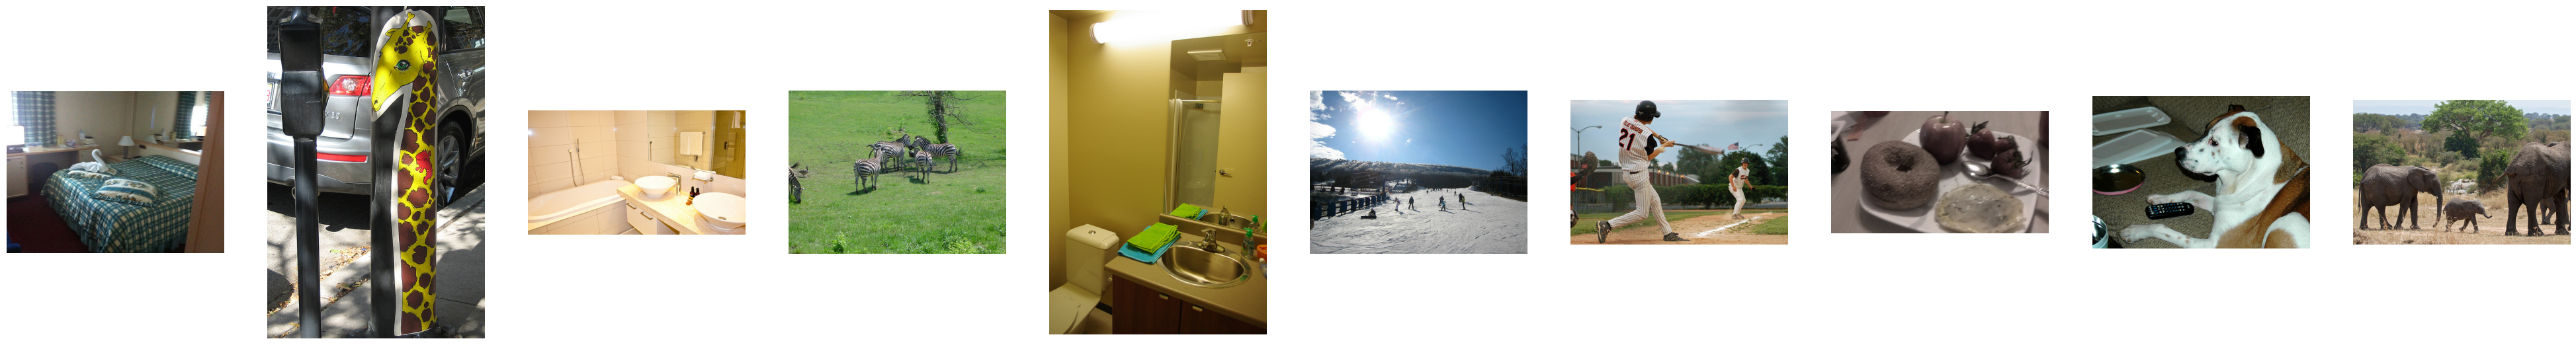

/home/tonypeng/anaconda3/envs/adaptfilter/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tonypeng/anaconda3/envs/adaptfilter/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'ResNet' object has no attribute 'features'

In [2]:
# I want to see the feature from traditional encoder. 
file_path = "../data/train2017/"
# get first 10 pictures
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models

def load_image(file_path):
    images = []
    for i, file_name in enumerate(os.listdir(file_path)):
        if i == 10:
            break
        image = cv2.imread(os.path.join(file_path, file_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images

def show_images(images):
    fig = plt.figure(figsize=(50, 50))
    for i, image in enumerate(images):
        ax = fig.add_subplot(1, 10, i+1)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

images = load_image(file_path)
show_images(images)

# load the model
from torchvision.models import resnet18
model_feature = resnet18(pretrained=True).features
# I need only the first feature extractor layer
# cut the model to layer1
model1 = torch.nn.Sequential(*model_feature[:5])
model2 = torch.nn.Sequential(*model_feature[5:])
model1.eval()
model2.eval()
# preprocess the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_images(images):
    images_tensor = []
    for image in images:
        image = Image.fromarray(image)
        image = transform(image)
        images_tensor.append(image)
    return torch.stack(images_tensor)

images_tensor = preprocess_images(images)
# get the feature
with torch.no_grad():
    features = model1(images_tensor)
# visualize the feature
fig = plt.figure(figsize=(50, 50))
for i, feature in enumerate(features):
    for j in range(10):
        ax = fig.add_subplot(10, 10, i*10+j+1)
        ax.imshow(feature[j,:,:], cmap='gray')
        ax.axis('off')
    if i == 2:
        break
plt.show()
# what if I make some feature to all zeros?
with torch.no_grad():
    # random list for zeroing out, no duplicate
    zero_list = np.random.choice(64, 40, replace=False)
    print(zero_list)
    # for i in range(10):
    #     features[i, zero_list, :, :] = 0
    # run the rest of the model
    output = []
    for i in range(10):
        print(features[i].unsqueeze(0).shape)
        output.append(model2(features[i].unsqueeze(0)))

    print(output.shape)

# something bugs here, we need to build the model by ourselves.

In [1]:
# mobilecode

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
import torchvision


slice_num = [3, 6, 12, 24, 48]
slices = {3: 3, 6: 3, 12: 6, 24: 12, 48: 24}


class mobilenet_slice_train(nn.Module):
    def __init__(self):
        super(mobilenet_slice_train, self).__init__()
        # Load the pre-trained MobileNet V2 model only once
        mobilenet_v2 = models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT")

        # Extract the features from the pre-trained model
        features = mobilenet_v2.features
        self.part1 = nn.Sequential(*features[:4])

        # Initialize ModuleList for the second part
        self.part2 = remaining_layers

        # Create part2 modules for each entry in slice_num
        for i in slice_num:
            C_in = 24
            C_out = slices[i]
            self.encoders.append(
                Block1(
                    l1=C_out * 2 + 24,
                    l2=C_out * 2 + 12,
                    l3=C_out + 6,
                    C_in=C_in,
                    C_out=C_out,
                )
            )
            self.upscale_layers.append(UpsampleNetwork(i, 24))

    def forward(self, x, i):
        base = self.part1(x)
        # Apply each part2 module to the output of part1
        sliced_bases = [self.encoders[k](base) for k in range(i + 1)]
        concat_bases = torch.cat(sliced_bases, dim=1)
        upscaled_base = self.upscale_layers[i](concat_bases)
        out = self.part2(upscaled_base)
        return out


class UpsampleNetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpsampleNetwork, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, in_channels * 2 + 6, kernel_size=3, stride=1, padding=1
        )
        self.upsample1 = nn.Upsample(
            scale_factor=4, mode="bilinear", align_corners=True
        )
        self.conv2 = nn.Conv2d(
            in_channels * 2 + 6,
            in_channels * 2 + 12,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        self.conv3 = nn.Conv2d(
            in_channels * 2 + 12, out_channels, kernel_size=3, stride=1, padding=1
        )
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(in_channels * 2 + 6)
        self.bn2 = nn.BatchNorm2d(in_channels * 2 + 12)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.dropout(self.bn1(self.conv1(x))))
        x = self.upsample1(x)
        x = self.relu(self.dropout(self.bn2(self.conv2(x))))
        x = self.relu(self.dropout(self.bn3(self.conv3(x))))
        return x


class Block1(nn.Module):
    def __init__(self, l1, l2, l3, C_in=24, C_out=12):
        super(Block1, self).__init__()
        self.layers = nn.Sequential(
            MobileNetBlock(
                in_channels=C_in, out_channels=l1, size=3, stride=1, padding=1
            ),
            MobileNetBlock(
                in_channels=l1, out_channels=l2, size=3, stride=2, padding=1
            ),
            MobileNetBlock(
                in_channels=l2, out_channels=l3, size=3, stride=1, padding=1
            ),
            MobileNetBlock(
                in_channels=l3, out_channels=C_out, size=3, stride=2, padding=1
            ),
        )

    def forward(self, x):
        x = self.layers(x)
        return x


class MobileNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, size, stride, padding):
        super(MobileNetBlock, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=size,
            stride=stride,
            padding=padding,
            groups=in_channels,
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(out_channels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.dropout(self.bn1(self.depthwise(x))))
        x = self.relu(self.dropout(self.bn2(self.pointwise(x))))
        return x
